<a href="https://colab.research.google.com/github/mpedraza98/MLTSA22_MPedraza/blob/main/HW2/StationaryTS_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports we have already seen
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#new imports we will learn to use
import statsmodels.api as sm # for the statistical analysis to find out if the TS is stationary
import glob #to sort files
from pandas.plotting import scatter_matrix #will make useful correlatin plots
import json #reads and writes json files, see programmatic data access notebooks
import os #this runs system level commands, see programmatic data access notebooks

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#some annoying wornings show up - suppress them with this
import warnings
warnings.filterwarnings('ignore')

In [4]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")

# data ingestion

use kaggle economic data accessing it programmatically at
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data#a.us.txt

Access it programmatically as was done for the TESLA data in https://github.com/fedhere/MLTSA22_FBianco/blob/main/Lab3ProgrammaticDataAccess/Kaggledata_load.ipynb

Save it in a directory called MLTSA22/HW2/data in your google drive 


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
#pip install kaggle

In [7]:
cd /content/drive/MyDrive

/content/drive/MyDrive


This cells are commented since they were used to retrieve the data from kaggle 

In [8]:
#!ls .kaggle/

In [9]:
#cd /content/drive/MyDrive/.kaggle

In [10]:
#!chmod 600 kaggle.json

In [11]:
#envs = json.load(open("kaggle.json", "r"))
#os.environ["KAGGLE_USERNAME"] = envs['username']
#os.environ["KAGGLE_KEY"] = envs['key']

In [12]:
#!kaggle datasets list -s stock

In [13]:
cd /content/drive/MyDrive/MLTSA22/HW2/data

/content/drive/MyDrive/MLTSA22/HW2/data


In [14]:
!pwd

/content/drive/MyDrive/MLTSA22/HW2/data


In [15]:
#!kaggle datasets download borismarjanovic/price-volume-data-for-all-us-stocks-etfs

In [16]:
#!unzip price-volume-data-for-all-us-stocks-etfs.zip

In [17]:
#use glob.glob to list the files in Data/Stocks. 
#This command returns a list, turn it into an array with np.array(<list>)
#Sort the array (alphabetically) with np.sort
files = glob.glob("Data/Stocks/*.txt")

In [18]:
files = np.array(files)
files = np.sort(files)

In [19]:
files

array(['Data/Stocks/a.us.txt', 'Data/Stocks/aa.us.txt',
       'Data/Stocks/aaap.us.txt', ..., 'Data/Stocks/zx.us.txt',
       'Data/Stocks/zyme.us.txt', 'Data/Stocks/zyne.us.txt'], dtype='<U28')

# read in the first 10 files in Data/Stock (first in alphabetical order.)

each file can be read with ```pd.read_csv()```

merge each file so that you end up with a single dataframe (e.g. call it tss)

```df1 = pd.read_csv()```

```df2 = pd.read_csv()```

```newdf = df.merge(df2)```

you want to merge on the date: this means the resulting dataframe will have a row for each date that is available in both files and all the columns of the files you are merging. To achieve this pass the argument ```on="Date"``` to ```df.merge()```

I also recommand you turn the Date column into the dataframe index

```tss.set_index("Date", inplace=True)```

In [20]:
#files paths are stored in the allfiles variable sorted alphabetically...

In [21]:
a = pd.read_csv(files[0])[["Close", "Date"]].merge(pd.read_csv(files[1])[["Date", "Close"]], on="Date")

In [22]:
a.set_index("Date", inplace = True)

In [23]:
files[1:10]

array(['Data/Stocks/aa.us.txt', 'Data/Stocks/aaap.us.txt',
       'Data/Stocks/aaba.us.txt', 'Data/Stocks/aac.us.txt',
       'Data/Stocks/aal.us.txt', 'Data/Stocks/aamc.us.txt',
       'Data/Stocks/aame.us.txt', 'Data/Stocks/aan.us.txt',
       'Data/Stocks/aaoi.us.txt'], dtype='<U28')

In [24]:
tss = pd.read_csv(files[0])[["Date", "Close"]]
tss.rename(columns = {"Close":files[0].split('/')[2][:-4]}, inplace = True)

for i in files[1:10]:
  temp = pd.read_csv(i)[["Date", "Close"]]
  temp.rename(columns = {"Close":i.split('/')[2][:-4]}, inplace = True)
  tss = tss.merge(temp, on = "Date")

tss["Date"] = pd.to_datetime(tss["Date"]).dt.date
tss.set_index("Date", inplace = True)

In [25]:
tss.head()

,a.us,aa.us,aaap.us,aaba.us,aac.us,aal.us,aamc.us,aame.us,aan.us,aaoi.us
Date,,,,,,,,,,
2015-11-11,36.901,17.779,24.50,33.38,22.56,43.524,20.75,4.7960,24.649,16.76
2015-11-12,36.734,17.206,25.00,33.23,22.50,43.044,19.17,4.8951,24.182,16.11
2015-11-13,36.030,17.581,25.26,32.19,22.68,42.603,17.50,4.6672,23.795,16.60
2015-11-16,36.577,18.242,25.02,32.94,22.58,41.994,15.58,4.8455,23.923,16.93
2015-11-17,37.607,18.197,24.62,32.86,22.52,41.473,12.59,4.9150,23.418,16.68


In [26]:
tss.shape

(447, 10)

In [27]:
tss.columns.values

array(['a.us', 'aa.us', 'aaap.us', 'aaba.us', 'aac.us', 'aal.us',
       'aamc.us', 'aame.us', 'aan.us', 'aaoi.us'], dtype=object)

#  data inspection

plot each time series (ts)

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


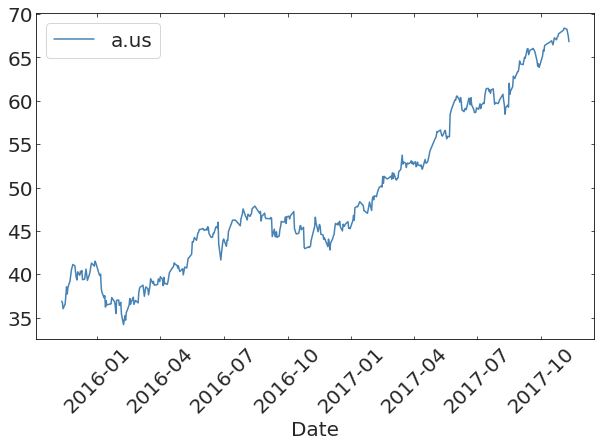

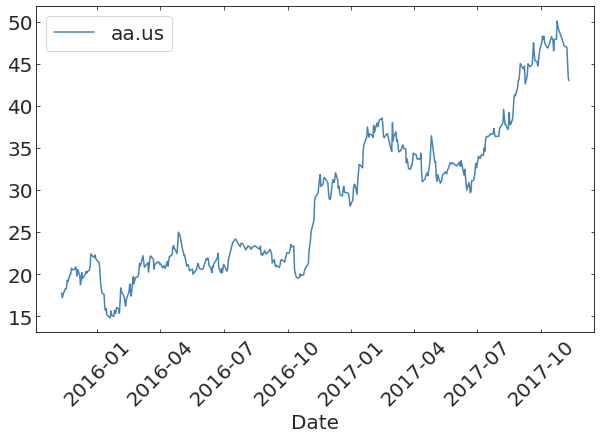

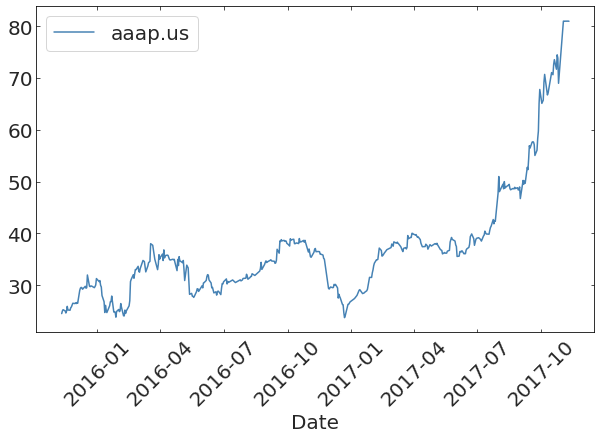

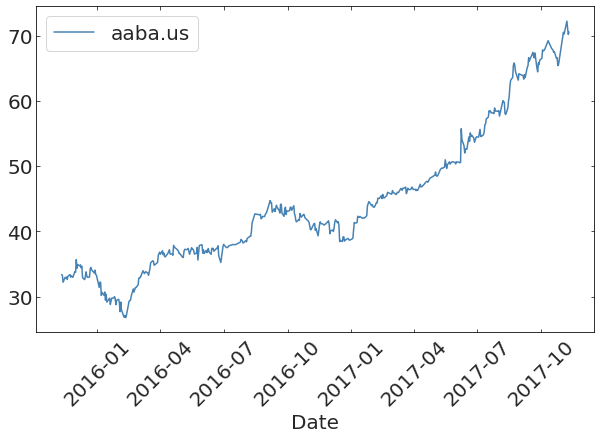

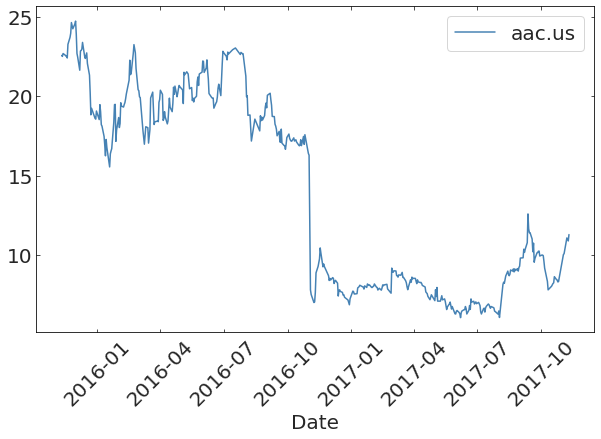

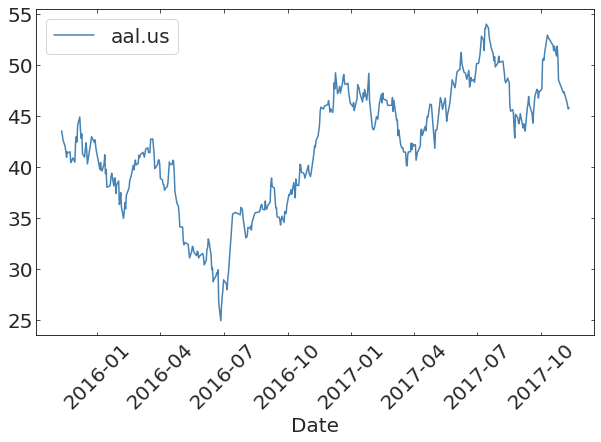

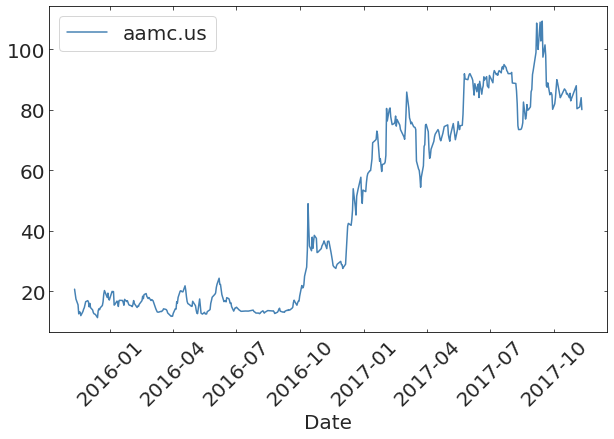

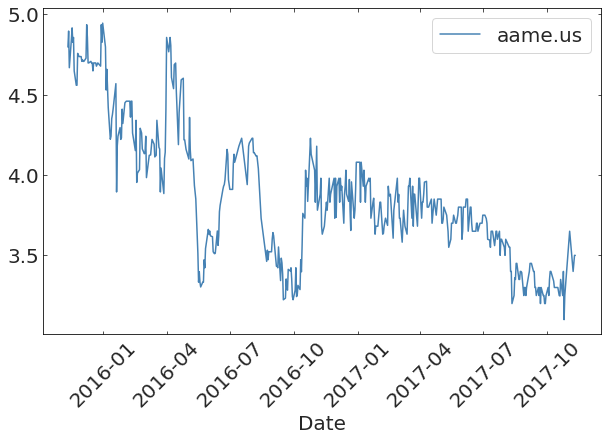

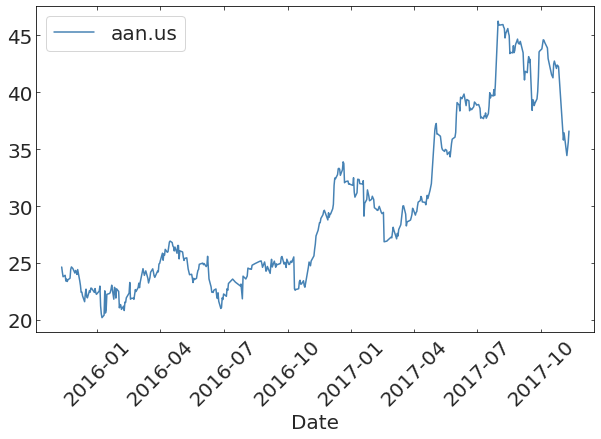

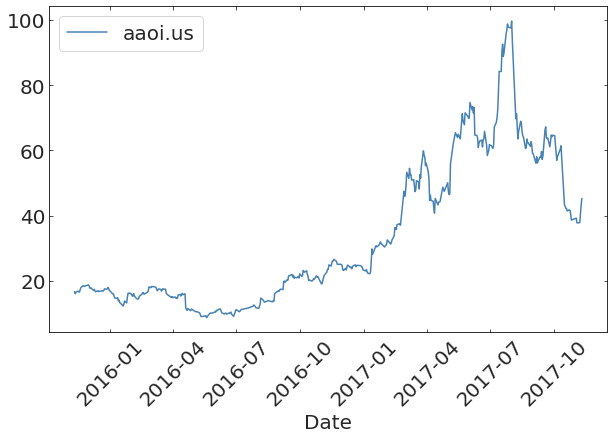

In [28]:
for i in tss.columns:
  pl.plot(tss.index.values, tss[i].values, label = i)
  pl.xticks(rotation = 45)
  pl.xlabel("Date")
  pl.legend()
  pl.show()

Fig 1: Closing price for ten stocks. At first sight it looks like none of them are stationary time series. Perhaps aal.us is the one closer to be stationary. Later we will run the ADFuller test to confirm.

## visualizing correlations

use ```pandas.plotting.scatter_matrix```  to look at the relationship between lightcurves

plot the pairwise correlation as a heatmap using ```pl.imshow()```. You can access the pairwise correlation with the dataframe method ```df.corr()```

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


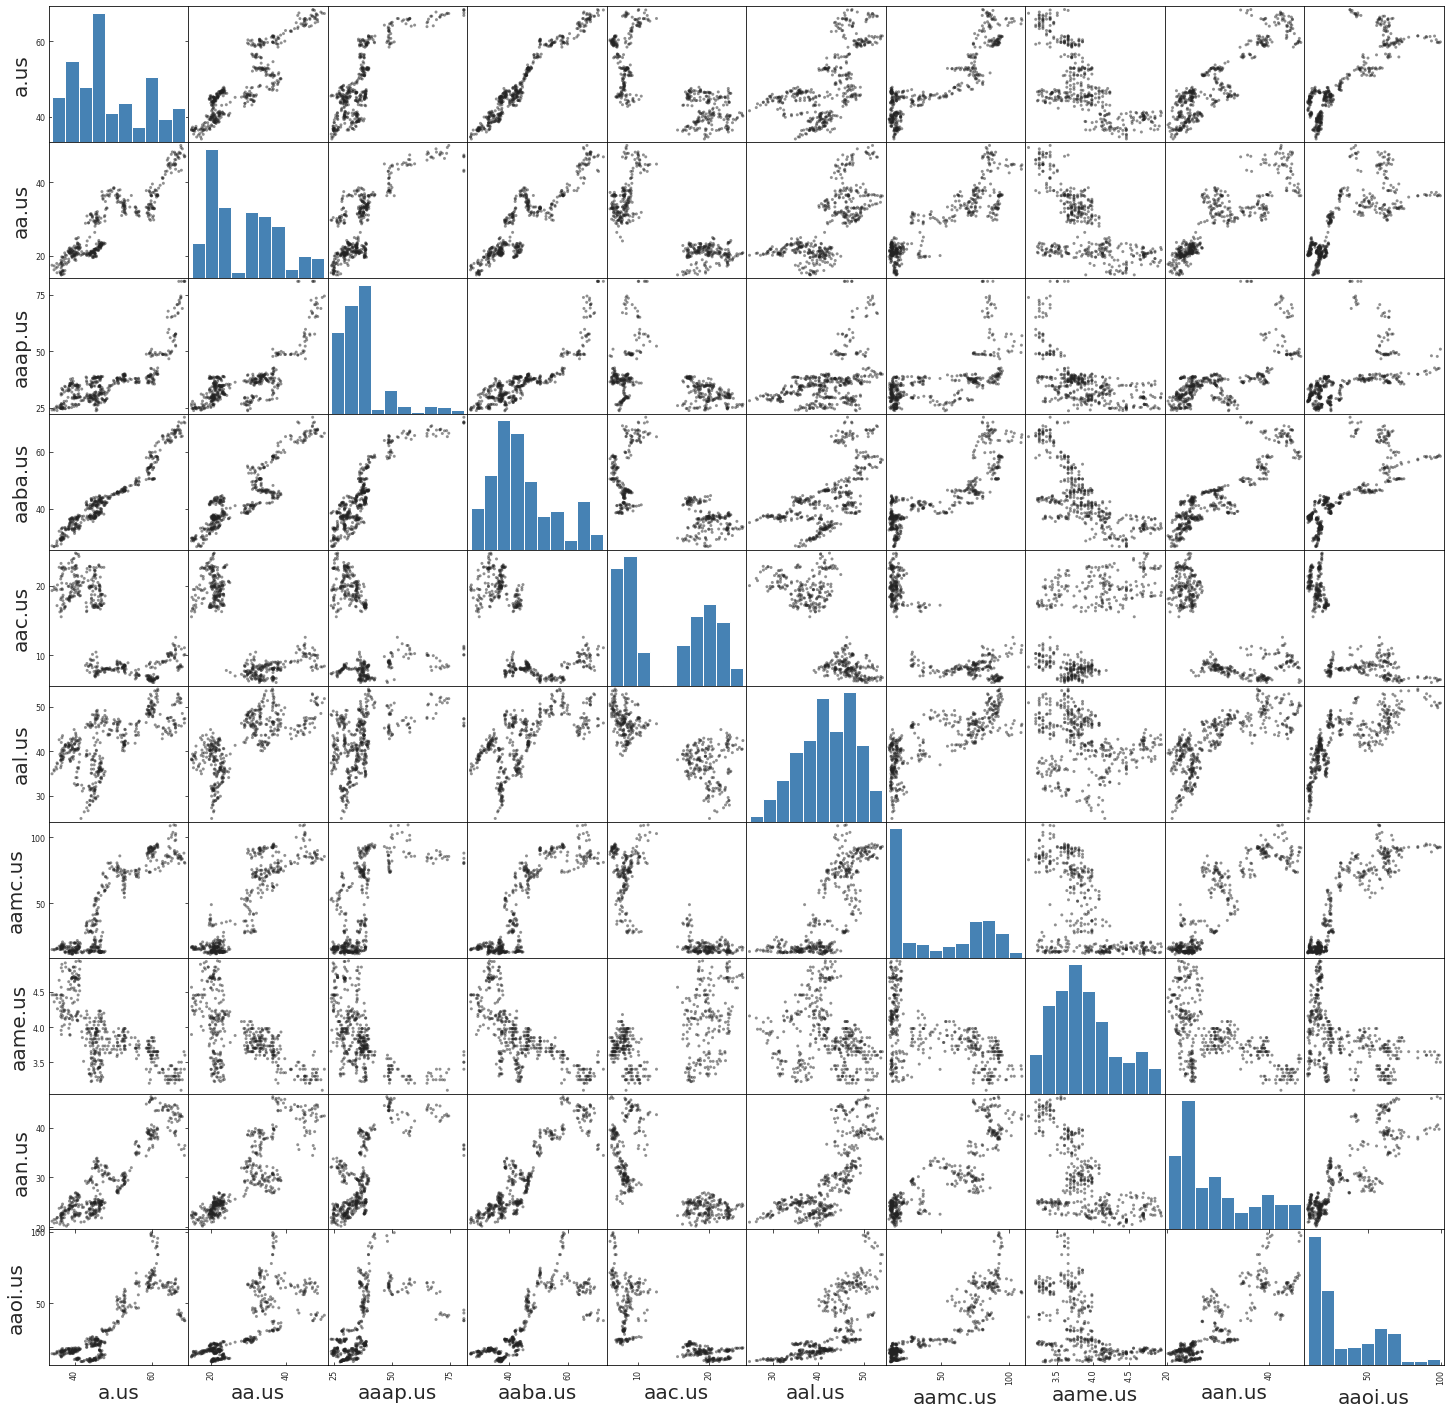

In [29]:
scatter_matrix(tss, figsize=(25,25), color="#222222");

Fig 2: The scatter matrix plots allow us to visualize a possible correlations between different stocks. In most of them it looks like it is the case, notable cases are the apparently strong linear correlation between *a.us* and *aaba.us*, and between this last one and *aa.us*.
It can also be noticed that *aac.us* shows no sign of correlation with any other of the stocks analyzed.

In [30]:
print("Correlation matrix of 2015-2017 stock values")
tss.corr()

Correlation matrix of 2015-2017 stock values


,a.us,aa.us,aaap.us,aaba.us,aac.us,aal.us,aamc.us,aame.us,aan.us,aaoi.us
a.us,1.000000,0.902139,0.800310,0.973457,-0.721867,0.621041,0.897263,-0.699609,0.905395,0.851239
aa.us,0.902139,1.000000,0.776600,0.904210,-0.791137,0.713229,0.893952,-0.606774,0.873520,0.766459
aaap.us,0.800310,0.776600,1.000000,0.872134,-0.423021,0.451520,0.621329,-0.573976,0.696179,0.560427
aaba.us,0.973457,0.904210,0.872134,1.000000,-0.670578,0.612989,0.849972,-0.709023,0.903785,0.809059
aac.us,-0.721867,-0.791137,-0.423021,-0.670578,1.000000,-0.785248,-0.868936,0.510986,-0.765267,-0.780147
aal.us,0.621041,0.713229,0.451520,0.612989,-0.785248,1.000000,0.780517,-0.219258,0.756808,0.746505
aamc.us,0.897263,0.893952,0.621329,0.849972,-0.868936,0.780517,1.000000,-0.544740,0.881631,0.904166
aame.us,-0.699609,-0.606774,-0.573976,-0.709023,0.510986,-0.219258,-0.544740,1.000000,-0.585002,-0.496371
aan.us,0.905395,0.873520,0.696179,0.903785,-0.765267,0.756808,0.881631,-0.585002,1.000000,0.860847
aaoi.us,0.851239,0.766459,0.560427,0.809059,-0.780147,0.746505,0.904166,-0.496371,0.860847,1.000000


findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


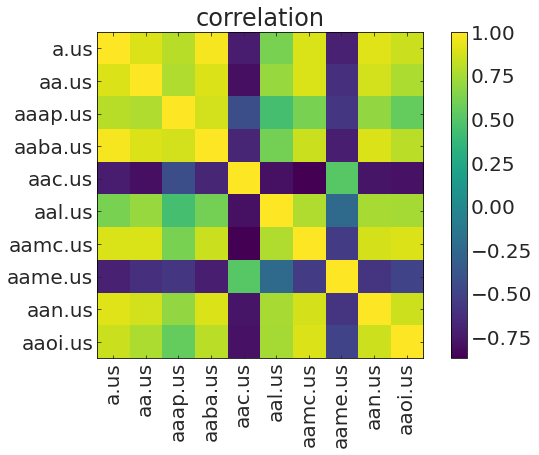

In [31]:
# you can visualize it as a heat map with imshow
pl.imshow(tss.corr())
pl.colorbar()
pl.title("correlation")
pl.xticks(range(len(tss.columns)), tss.columns, rotation=90)
pl.yticks(range(len(tss.columns)), tss.columns);


Fig 3: Correlation matrix plot for the first 10 stocks. This figure let us confirm some of our suppositions based on the scatter matrix plot (Fig 2). On the one hand, it is clear that *aac.us* has no correlation with most of the other stocks and that *a.us* and *aaba.us* are strongly correlated, although we can not conclude yet that such correlation is linear.

## testing for stationarity
test if each of these time series is stationary using the AD fuller test using ```statsmodels.api.tsa.stattools.adfuller()```

```for f in tss.columns:
    sm.tsa.stattools.adfuller(tss[c])```

Have the code automatically print a statement about wheather the ts is stationary for each ts (for example in a for loop).

You will have to set a statistival threshold - choose 2-sigma. What fraction of a gaussian distribution is not contained inside of 2-sigma? this is the threshold you want to pass

In [39]:
print("Stationarity results from the AD Fuller test at a p-value of 0.05")
s = "Stock \t\tp-value \tStationary\n"
for i in tss.columns:
  test = sm.tsa.stattools.adfuller(tss[i])
  s = s + i + "\t\t" + str(format(test[1], '.2f')) + "\t\t" + str(test[1]<0.05) + "\n"

print(s)

Stationarity results from the AD Fuller test at a p-value of 0.05
Stock 		p-value 	Stationary
a.us		0.97		False
aa.us		0.86		False
aaap.us		1.00		False
aaba.us		1.00		False
aac.us		0.50		False
aal.us		0.51		False
aamc.us		0.82		False
aame.us		0.04		True
aan.us		0.73		False
aaoi.us		0.61		False



After the AD Fuller test we see that the only stationary stock is *aame.us*